### Meta-Prod2Vec Embedding
Meta-prod2vec is a product recommendation algorithm that utilizes word2vec, a neural network-based technique for natural language processing, to generate product embeddings. These embeddings are then used to make recommendations based on the similarities between different products. The algorithm takes into account not only the product itself, but also its associated metadata, such as its category, brand, and customer reviews. This allows for more accurate and personalized recommendations, as it takes into account both the product's features and how it has been perceived by other customers. The algorithm can also be used to cluster products into groups based on their similarities, which can be useful for merchandising and product discovery.

In the first version, we try to leverage side information including 'merch_division_nm','short_desc','merch_subcat_nm' data and use it to provide more information of prodct to product connection

note that the file could talk +15 minute to run due to computational time on preprocessing the data

In [1]:
import gensim
from gensim.models.word2vec import Word2Vec
import pandas as pd
import numpy as np
# Tokenize the data and add it to the data list

# Random sample

In [2]:
product_detail_detail_path = "clean_data/cleaned_products_detailed.csv"
df_product_standard = pd.read_csv(product_detail_detail_path)
df_detailed = df_product_standard[['ctr_product_num','attr_value_en_sentence']]
df_detailed = df_detailed.dropna()
df_detailed = df_detailed.drop_duplicates()
df_detailed_subset = df_detailed.sample(frac=1)


# Input meta data including merch_division_nm,short_desc,merch_subcat_nm and target merch_lob_nm

In [3]:
path_standard = "Data\product\product_standard_attributes.csv" 

# put it in data farme
df_product_standard = pd.read_csv(path_standard, low_memory=False) #lazyway to solve low memory issue
df_right =df_product_standard[['ctr_product_num','merch_lob_nm','package_depth_qty','short_desc','package_height_qty','package_width_qty','package_volume_qty','package_weight_qty']]

df_right['ctr_product_num'] = pd.to_numeric(df_right['ctr_product_num'], errors='coerce')
df_right = df_right.dropna(subset=['ctr_product_num'])
df_right['ctr_product_num'] = df_right['ctr_product_num'].astype('int')
df_detailed_subset = df_detailed_subset.merge(df_right, on='ctr_product_num', how='left')

C:\Users\Yixin\AppData\Local\Temp\ipykernel_23272\271546728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_right['ctr_product_num'] = pd.to_numeric(df_right['ctr_product_num'], errors='coerce')


# Check label imbalance, undersampling

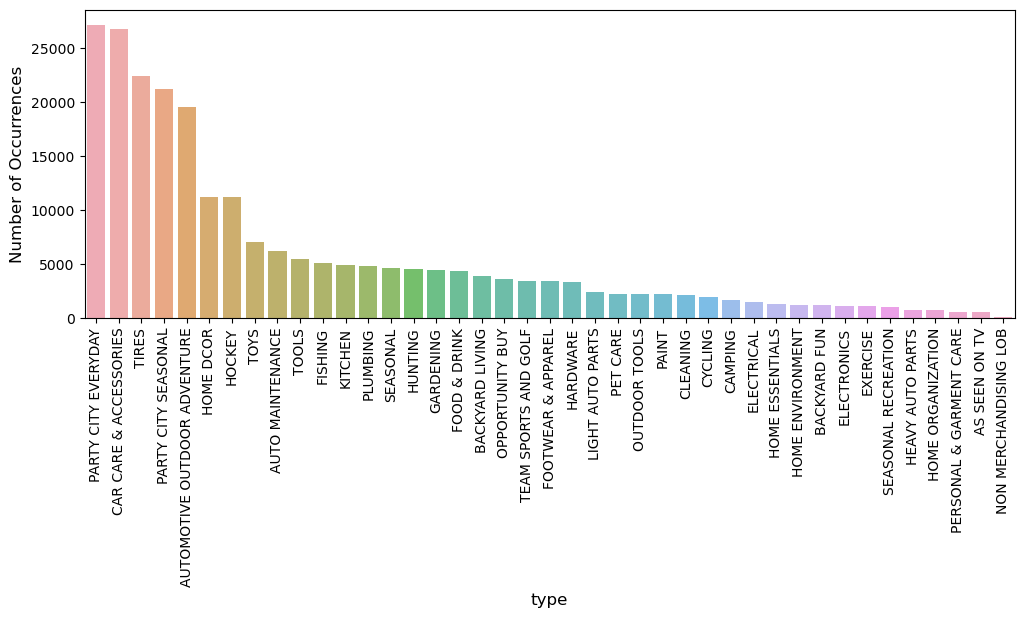

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
cnt_pro = df_detailed_subset['merch_lob_nm'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x = cnt_pro.index, y = cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('type', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [5]:
# nMax = 2500 #change to 2500

# df_detailed_subset = df_detailed_subset.groupby('merch_lob_nm').apply(lambda x: x.sample(n=min(nMax, len(x))))

# #print(df_detailed_subset['merch_lob_nm'].value_counts())

In [6]:
# df_detailed_subset = df_detailed_subset[df_detailed_subset.attr_value_en_sentence != 'Na']

# Clean text

In [7]:
# ! pip install lxml


In [8]:
# from bs4 import BeautifulSoup
# import re
# def cleanText(text):
#     text = BeautifulSoup(text,  "html.parser").text
#     text = re.sub(r'\|\|\|', r' ', text) 
#     text = re.sub(r'http\S+', r'<URL>', text)
#     text = text.lower()
#     text = text.replace('x', '')
#     text = text.replace(',', ' ')
#     return text
# df_detailed_subset['attr_value_en_sentence'] = df_detailed_subset['attr_value_en_sentence'].apply(cleanText)

C:\Users\Stephen\AppData\Local\Temp\ipykernel_14716\3733820858.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text,  "html.parser").text


In [6]:
df_detailed_subset

,ctr_product_num,attr_value_en_sentence,merch_lob_nm,package_depth_qty,short_desc,package_height_qty,package_width_qty,package_volume_qty,package_weight_qty
0,8992153,BALLISTIC RATED SHOOTING GLASSESFOUR INTERCHAN...,OPPORTUNITY BUY,8.0,OB-GLS CMBO PRO,4.5,18.5,0.096354,0.458
1,4830877,Hybrid kickpointJetstream bladeJetspeed shaft ...,HOCKEY,64.0,STK CCM JSPO IN65R30,1.3,0.8,0.034722,1.350
2,1274187,"BikeMaster LeversMade of tough, high-quality 6...",AUTOMOTIVE OUTDOOR ADVENTURE,11.6,71314 ATV AND MOTO M,1.0,5.1,0.034236,0.440
3,8424920,Create a festive atmosphere and provide entert...,PARTY CITY EVERYDAY,14.8,54X96IN TC ART PRTY,9.0,8.5,0.054631,0.265
4,545552,"Use the Sonicrafter 1-1/8"" bi-metal end cut bl...",TOOLS,11.0,"RK 1-3/16"" WPC BLA",13.8,24.0,0.021930,0.161
...,...,...,...,...,...,...,...,...,...
235413,774081,"Ideal for: Pike, Walleye Pre-rigged softplasti...",FISHING,2.0,"XC LIVE WALLEYE 4""",7.0,10.0,0.004501,0.119
235414,467322,"Easy install caf rodNo need to measure5/8"" dia...",HOME DCOR,6.6,"CAFE ROD BN 18-48""",3.4,25.6,0.082893,1.195
235415,1759034,Heated Insoles are just what you need to keep ...,HUNTING,12.7,RECHRG HEAT SOL XL,2.1,5.1,0.078707,1.058
235416,7741167,Bohemian-chic flair to folkloric and formal Pe...,HOME DCOR,95.0,SFV MO225 8X11,8.0,8.0,3.518519,41.000


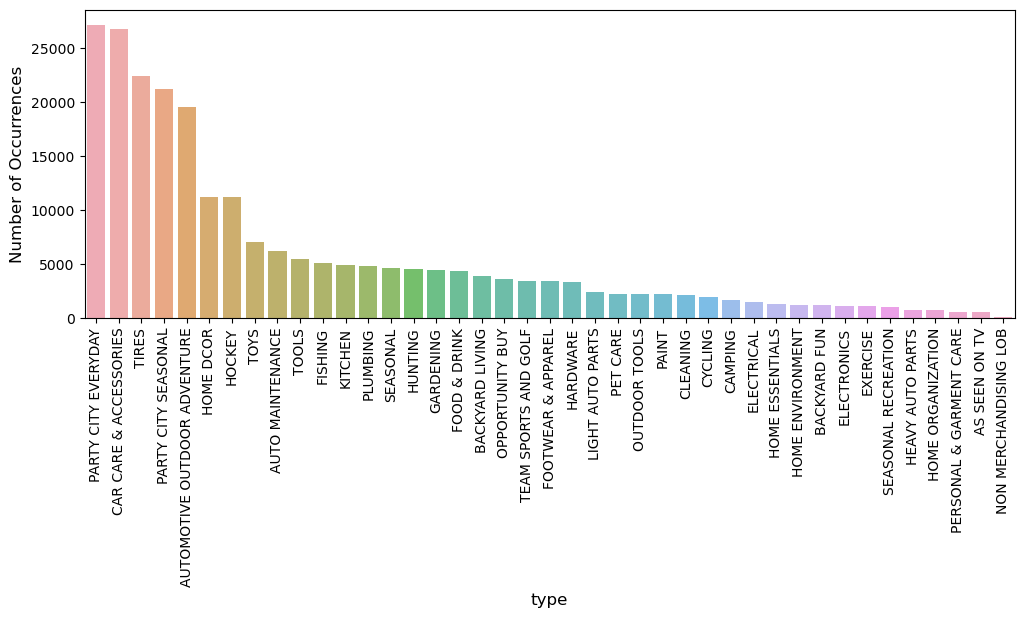

In [7]:
cnt_pro = df_detailed_subset['merch_lob_nm'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x = cnt_pro.index, y = cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('type', fontsize=12)
plt.xticks(rotation=90)
plt.show();

# Create input data, append meta data together with product description

In [8]:
#df_right =df_product_standard[['ctr_product_num','merch_lob_nm','package_depth_qty','short_desc','package_height_qty','package_width_qty','package_volume_qty','package_weight_qty']]


docLabels = []
# getting all the names of all json files
docLabels = [f for f in df_detailed_subset['package_depth_qty']]

sdecLabels = []
# getting all the names of all json files
sdecLabels = [f for f in df_detailed_subset['short_desc']]

subCatLabels = []
# getting all the names of all json files
subCatLabels = [f for f in df_detailed_subset['package_height_qty']]
widthLabels = [f for f in df_detailed_subset['package_width_qty']]
volumnLabels = [f for f in df_detailed_subset['package_volume_qty']]
weightLabels = [f for f in df_detailed_subset['package_weight_qty']]

In [12]:
#df_detailed_subset['attr_value_en_sentence'][0] + 'division_Name: ' + docLabels[0] + ' '+ 'short_description: ' + sdecLabels[0]

In [9]:
data = []
j = 0
for i, row in df_detailed_subset.iterrows():
    #print(row['attr_value_en_sentence'])
    #data.append(row['attr_value_en_sentence'].split())
    output = 'package depth is ' + str(docLabels[j]) + ' ' + 'short_description is ' + str(sdecLabels[j]) + ' ' + 'package height is ' + str(subCatLabels[j]) + ' '+'package width is ' + str(widthLabels[j]) + ' '+'package volumn is ' + str(volumnLabels[j]) + ' ' +'package weight is ' + str(weightLabels[j]) + ' ' + 'full description is ' + str(row['attr_value_en_sentence'])
    data.append(output.split())
    j+=1
# Train the model
#model = Word2Vec(data, min_count=1)

# Data Preview

the input data used include:
- attr_value_en_sentence: long description
- package_depth_qty: product meta data
- short_desc: product meta data
- package_height_qty: product meta data
- package_width_qty: product meta data
- package_volume_qty: product meta data
- package_weight_qty: product meta data

In [10]:
df_detailed_subset.head()

,ctr_product_num,attr_value_en_sentence,merch_lob_nm,package_depth_qty,short_desc,package_height_qty,package_width_qty,package_volume_qty,package_weight_qty
0,8992153,BALLISTIC RATED SHOOTING GLASSESFOUR INTERCHAN...,OPPORTUNITY BUY,8.0,OB-GLS CMBO PRO,4.5,18.5,0.096354,0.458
1,4830877,Hybrid kickpointJetstream bladeJetspeed shaft ...,HOCKEY,64.0,STK CCM JSPO IN65R30,1.3,0.8,0.034722,1.350
2,1274187,"BikeMaster LeversMade of tough, high-quality 6...",AUTOMOTIVE OUTDOOR ADVENTURE,11.6,71314 ATV AND MOTO M,1.0,5.1,0.034236,0.440
3,8424920,Create a festive atmosphere and provide entert...,PARTY CITY EVERYDAY,14.8,54X96IN TC ART PRTY,9.0,8.5,0.054631,0.265
4,545552,"Use the Sonicrafter 1-1/8"" bi-metal end cut bl...",TOOLS,11.0,"RK 1-3/16"" WPC BLA",13.8,24.0,0.021930,0.161


In [11]:
data[0]

['package',
 'depth',
 'is',
 '8.0',
 'short_description',
 'is',
 'OB-GLS',
 'CMBO',
 'PRO',
 'package',
 'height',
 'is',
 '4.5',
 'package',
 'width',
 'is',
 '18.5',
 'package',
 'volumn',
 'is',
 '0.096354',
 'package',
 'weight',
 'is',
 '0.458',
 'full',
 'description',
 'is',
 'BALLISTIC',
 'RATED',
 'SHOOTING',
 'GLASSESFOUR',
 'INTERCHANGEABLE',
 'LENSESWRAP',
 'AROUND',
 'FRAME',
 'FOR',
 'WIDE',
 'FIELD',
 'OF',
 'VISIONTILT',
 'AND',
 'LENGTH',
 'ADJUSTABLE',
 'TEMPLES']

for each input, it will be a texual input with structure:

division_Name:  + merch_division_nm + short_description:  + short_desc + sub_Cat: + merch_subcat_nm + full_description: + attr_value_en_sentence

# Create Doc2Vec embedding with input data

In [12]:
import gensim
import gensim.downloader as api
#dataset = api.load("text8")
#data = [d for d in dataset]
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
data_for_training = list(tagged_document(data))
#print(data_for_training[:1])
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=50)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)
#print(model.infer_vector(['violent', 'means', 'to', 'destroy', 'the','organization']))

In [13]:
value = []
for i in data:
    value.append(model.infer_vector(i,epochs=30))

In [17]:
#print(model.infer_vector(['Travel', 'poker', 'chips']))
value[0]

[array([-0.07357742,  0.048452  ,  0.10256608, -0.3633058 , -0.72639036,
         0.09146613,  0.35767207, -0.6111638 ,  0.19339408,  0.20934047,
        -0.48464975,  0.26608455, -0.689624  , -0.04748333, -0.15551884,
         0.16250563,  0.32577172, -0.30507344,  0.07597799, -0.3843616 ,
        -0.73729926,  0.4186762 ,  0.88345367,  0.0016132 , -0.6520298 ,
         0.53012496, -0.07431671, -0.31887525, -0.6214611 ,  0.19905645,
         0.25681365, -0.28129148, -0.1738893 , -0.46709847, -0.38496512,
         0.27994895, -0.05035362, -0.47030437, -0.01591184,  0.28911155,
         0.7024692 , -0.0987566 , -0.26243514, -0.33335596,  0.6372816 ,
        -0.24990883, -0.35401317, -0.10655861,  0.42272505,  0.15083094],
       dtype=float32),
 array([-3.28540802e-01, -3.27311344e-02, -5.84369861e-02, -1.21944942e-01,
        -4.88860250e-01, -1.92353316e-02,  1.08515844e-01,  6.43746629e-02,
        -8.48895833e-02,  1.14160128e-01, -3.09727073e-01,  1.02205895e-01,
        -4.0090128

# Save embedding to csv to input into evaluation

In [14]:
df_embedding = pd.DataFrame(value,index = df_detailed_subset['ctr_product_num'])
df_embedding.to_csv("embeddings/meta_prod2vec_all.csv")

In [15]:
df_product_detailed = pd.read_csv('clean_data/cleaned_products_detailed.csv')
df_product_standard = pd.read_csv('clean_data/cleaned_products.csv')

df_product_standard = df_product_standard[["ctr_product_num", "merch_lob_nm"]]

# Evaluate on based MLP model

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score



def score_cv(model, X, y, k = 0):
    k_folds = KFold(n_splits = k)
    #acc = None
    #acc = cross_val_score(model, X, y, cv=k_folds, n_jobs= -1)
    #f1_macro = cross_val_score(model, X, y, scoring="f1_macro", cv=k_folds, n_jobs= -1)

    scoring = {"Accuracy": make_scorer(accuracy_score),
               "Top_K": make_scorer(top_k_accuracy_score),
               "F1 Score": make_scorer(f1_score, average='weighted')}

    scores = cross_validate(model, X, y, cv=k_folds, n_jobs= -1, return_train_score=True)

    return scores, None

results = []

filename = 'meta_prod2vec_all.csv'
print("Scoring", filename)
test_embedding = pd.read_csv("embeddings/" + filename, index_col=0, header=0)
#test_embedding = test_embedding[:500]
df_combined = test_embedding.join(df_product_standard.set_index("ctr_product_num"))

df_combined.dropna(inplace=True)
df_combined.merch_lob_nm = pd.Categorical(pd.factorize(df_combined.merch_lob_nm)[0])

drop_for_X = ["merch_lob_nm"]

X = df_combined.drop(columns=drop_for_X)
Y = df_combined[["merch_lob_nm"]]

model = ("MLP_3", MLPClassifier(hidden_layer_sizes=(150, 100, 50), random_state=1, max_iter=300))
print(model[0])
acc, f1_micro = score_cv(model[1], X, Y, k=5)
results.append((filename, model[0], [acc, f1_micro]))

Scoring meta_prod2vec_all.csv
MLP_3


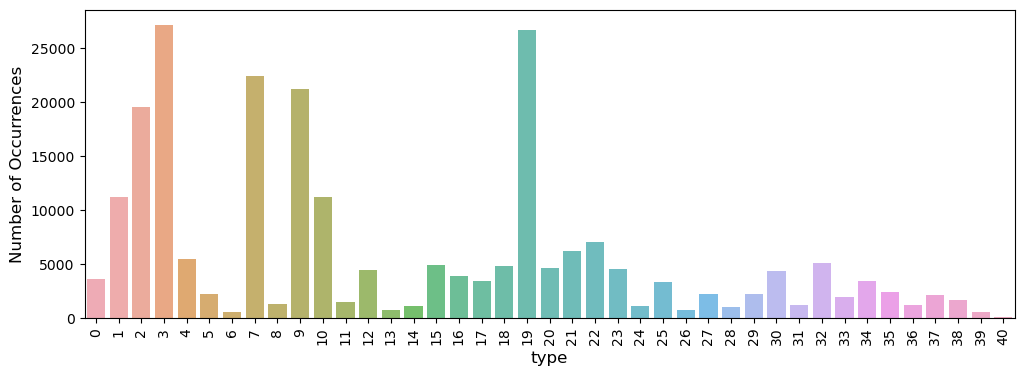

In [21]:
df_combined
cnt_pro = df_combined['merch_lob_nm'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x = cnt_pro.index, y = cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('type', fontsize=12)
plt.xticks(rotation=90)
plt.show();

# Test result

In [22]:
for result in results:
    print(result[0])
    for i in result[2][0]:
        print(i, result[2][0][i])

meta_prod2vec_all.csv
fit_time [719.00783062 708.2864418  650.52785873 718.60972118 721.54478788]
score_time [0.23257327 0.22707915 0.23440242 0.22441101 0.21957707]
test_score [0.59222286 0.59672362 0.59026045 0.59403596 0.59384399]
train_score [0.67894776 0.67955035 0.67760393 0.6734178  0.67542288]


In [24]:
label = []
label = list(df_embedding.index)

# Save to pickle for visualization

In [ ]:
import pickle
with open("embeddings/prod2vec_embedding_value.data", "wb") as fp:   #Pickling
    pickle.dump(value, fp)
with open("embeddings/prod2vec_embedding_label.data", "wb") as fp:   #Pickling
    pickle.dump(label, fp)